<a href="https://colab.research.google.com/github/leo14993/analise-ligas-heas/blob/main/Analise_HEAs_com_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importando as dependencias do projeto

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib.ticker import PercentFormatter

#selecao e separação de dados
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_val_predict
  )

#pre processamento de dados
from sklearn.preprocessing import (
    OneHotEncoder, 
    LabelEncoder, 
    OrdinalEncoder, 
    StandardScaler
  )

# avaliação resultados
from sklearn.metrics import (
    roc_curve,
    accuracy_score, 
    confusion_matrix,
    multilabel_confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
  )

#modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import SelectFromModel

#sobreamostragem
from imblearn.over_sampling import (
    SMOTE, 
    ADASYN,
    BorderlineSMOTE, 
    KMeansSMOTE, 
    SVMSMOTE
  )

import warnings
warnings.filterwarnings('ignore')

# ! pip install yellowbrick
# from yellowbrick.classifier import ROCAUC



## 2. Importando os dados e removendo colunas não utilizadas, e removendo linhas duplicadas

In [2]:
# caminho google colab
df = pd.read_csv('/content/drive/MyDrive/Documentos/TCC/HEAs_Machine_Learning/dados/df_final2.csv', error_bad_lines=False, sep=';')

# removendo os dados de componentes quimicos para gerar arquivo de analise
# apenas considerando as fases e outras variaveis
# df = df.drop(['Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
#               'Mo','Ti','Cu','V','Zr','Ta','Hf','W' ],axis=1)

df.drop(['PROPERTY: Type of test', 'PROPERTY: YS (MPa)' , 'Alloy name', 'index'],axis=1, inplace=True)
# df = df.drop(['PROPERTY: Type of test', 'PROPERTY: YS (MPa)' ],axis=1)


* Etapa de analise de dados(opcional)

In [3]:
# jupyter
# # !pip install pandas-profilling

# # colab

# #antes de executar o profile report é necessario reiniciar o ambiente de execução,
# # instalar o pandas profiling para verificar a ausencia de alguma dependencia
# # # # reiniciar novamente e importar 
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# from pandas_profiling import ProfileReport

# # prof = ProfileReport(df)
# # prof.to_file(output_file='analise_dados_inicial.html')

# prof = ProfileReport(df_featured)
# prof.to_file(output_file='analise_dados_feature_selection.html')


## 3. Conversão das variáveis categóricas em numeros inteiros / trocando valores nulos por zero

In [4]:
# Tornando variaveis categóricas em numeros ordinais

processing_method_ord_enc = \
  OrdinalEncoder().fit(df[['PROPERTY: Processing method']])
#   LabelEncoder().fit(df[['PROPERTY: Processing method']])


# alloy_name_ord_enc = OrdinalEncoder().fit(df[['Alloy name']])
microstructure_ord_enc = \
  OrdinalEncoder().fit(df[['PROPERTY: Microstructure']])
  # LabelEncoder().fit(df[['PROPERTY: Microstructure']])
  


df['PROPERTY: Processing method'] = \
  processing_method_ord_enc.transform(df[['PROPERTY: Processing method']])
# df['Alloy name'] = alloy_name_ord_enc.transform(df[['Alloy name']])
df['PROPERTY: Microstructure'] = \
  microstructure_ord_enc.transform(df[['PROPERTY: Microstructure']])

a = microstructure_ord_enc.inverse_transform(df[['PROPERTY: Microstructure']])


df.fillna(0,inplace=True)

df_droped_duplicates = df.drop_duplicates()
df_droped_duplicates.reset_index(inplace=True)

df_droped_duplicates.drop(['index'],axis=1, inplace=True)



## 3.1 Funções e constantes necessárias para o projeto

### 3.1.1 Constantes

In [5]:
K_FOLDS = 10

N_VALIDATORS = 10

TEST_SIZE = 0.3

RANDOM_STATE = 388

DEFAULT_FOREST = RandomForestClassifier(random_state=54)

MICROSTRUCTURES = ['CCC','CCC ++','CCC B2','CFC','CFC ++','CFC CCC','OUTROS']

### 3.1.1 Plotar matriz de confusão

In [6]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          file_name=None,
                          show_accuracy=False):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    stats_text = ""
    
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if show_accuracy:
          if len(cf)==2:
              #Metrics for Binary Confusion Matrices
              precision = cf[1,1] / sum(cf[:,1])
              recall    = cf[1,1] / sum(cf[1,:])
              f1_score  = 2*precision*recall / (precision + recall)
              stats_text = "\n\nAcurácia={:0.3f}\nPrecisão={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                  accuracy,precision,recall,f1_score)
          else:
              stats_text = "\n\nAcurácia={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # --------------
    # cf_sum = np.sum(cf, axis=1, keepdims=True)
    # cf_perc = cf / cf_sum.astype(float) * 100
    # annot = np.empty_like(cf).astype(str)
    # nrows, ncols = cf.shape
    # for i in range(nrows):
    #     for j in range(ncols):
    #         c = cf[i, j]
    #         p = cf_perc[i, j]
    #         if i == j:
    #             s = cf_sum[i]
    #             annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
    #         #elif c == 0:
    #         #    annot[i, j] = ''
    #         else:
    #             annot[i, j] = '%.2f%%\n%d' % (p, c)
    # --------------------

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)

    image_plot = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    

    if xyplotlabels:
        plt.ylabel('Microestruturas reais')
        plt.xlabel('Microestruturas previstas' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    if file_name:
      plt.savefig(f'{file_name}.png')


### 3.1.2 Matriz de confusão utilizada no relatório

In [7]:
def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, 
                figsize=(17,17), cmap="Blues", title=None):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1.1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%' % (p)
                # annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%' % (p)
                # annot[i, j] = '%.2f%%\n%d' % (p, c)

    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'Microestruturas reais'
    cm.columns.name = 'Microestruturas previstas'
    fig, ax = plt.subplots(figsize=figsize)
    
    # plt.yticks(va='center')

    if title:
        plt.title(title)

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, 
                cbar_kws={'format':PercentFormatter()}, 
                yticklabels=classes, cmap=cmap)
    plt.savefig(filename,  
                bbox_inches='tight'
                )

### 3.1.3 Função para gerar relatório e matriz de confusão

In [8]:
#1. predition with cross validation
is_float = lambda x : x.replace('.','',1).isdigit()

inverse_transform_microstructure = \
  lambda x : microstructure_ord_enc.inverse_transform([[float(x)]])[0][0]

categorical_key = \
  lambda x : inverse_transform_microstructure(x) if is_float(x) else x

def get_reports(x_train,
                y_train, 
                models, 
                title=None, 
                display_cm=True,
                k_folds=10,
                display_title_cm=False,
                filename=None,
                x_test=None,
                y_test=None,
                validate=False,
                ignore_zero=False,
                report=True):
  print( f'======= {title} ==========')

 
    

  if type(models)!=list:
    models = [models]

  for model in models:
    print(f' Modelo: {str(model.__class__.__name__)}')

    if validate and (not x_test.empty and not y_test.empty):

      homolog_fit = model.fit(
      x_train,
      y_train.values.reshape(-1,)
      )

      y_test_pred = homolog_fit.predict(x_test)

      clf_report_oversampled_homolog = classification_report(
          y_test, 
          y_test_pred,
          output_dict=True
        )

      microstructure_multilabel_confusion_matrix = \
        multilabel_confusion_matrix(
          y_test, 
          y_test_pred,
        )

      microstructure_confusion_matrix = \
        confusion_matrix(
          y_test, 
          y_test_pred,
        )

      clf_report = classification_report(
          y_test, 
          y_test_pred,
          output_dict=True
        )
    else:
      y_train_pred = cross_val_predict(
          model, 
          x_train, 
          y_train.values.reshape(-1,), 
          cv=k_folds
        )

      #2. fitting model with all data
      default_forest_fit = model.fit(
          x_train, 
          y_train.values.reshape(-1,)
        )

      #3. Confusion matrix with Diagonal 
      confusion_matrix_microstructure = confusion_matrix(
            y_train, 
            y_train_pred
        )

      #4. confusion matrix with TP, TN, FP, FN
      multilabel_confusion_matrix_microstructure = \
        multilabel_confusion_matrix(y_train, y_train_pred)

      #5. get classification report 
      # with the report, we have a bigger picture, with precision and recall for each class
      clf_report = classification_report(
          y_train, 
          y_train_pred, 
          output_dict=True
        ) 

    f1_scores = []
    for i in clf_report:
      if is_float(i):
        if ignore_zero and clf_report[i]['f1-score'] == 0:
          continue
        f1_scores.append(clf_report[i]['f1-score'])
      
      try:
        if 'accuracy' in i:
          print(f"acuracia: {clf_report[i]}")
      except Exception as e:
        print(e)

    print('media f1 scores: ',mean(f1_scores))

    # print(f' ese e o cara {i} -')
    
    # print(f' o que eh o i: {i}')

    #6. applyting name of microstructures on axis
    clf_report = {categorical_key(k):v for (k,v) in clf_report.items()}

    #7. creating dataframe
    df_classification_report = pd.DataFrame(clf_report).transpose()
    
    
      
    if validate and (not x_test.empty and not y_test.empty):

      if report:
        print('\n relatorio, n=', 
        x_test.shape)
        print('\n', df_classification_report, '\n')

      if display_cm:
        if not display_title_cm:
          title=None
        cm_analysis(y_test,
              y_test_pred, 
              filename, 
              [0.0,1.0,2.0,3.0,4.0,5.0,6.0], 
              MICROSTRUCTURES, 
              figsize=(10,8),
                cmap="Reds",
                title=title)
  
    else:
      if report:
        print('\n relatorio, n=', 
        x_train.shape)
        print('\n', df_classification_report, '\n')
      if display_cm:
        if not display_title_cm:
          title=None
        cm_analysis(y_train,
              y_train_pred, 
              filename, 
              [0.0,1.0,2.0,3.0,4.0,5.0,6.0], 
              MICROSTRUCTURES, 
              figsize=(10,8),
                cmap="Reds",
                title=title)
      
    return df_classification_report

  # except Exception as err:
  #   print(err)

## 4. Separar o conjunto das variaveis e o conjunto dos alvos

### 4.1 Separando treino e teste

In [9]:

# microstructures = ['BCC','BCC ++','BCC B2','FCC','FCC ++','FCC BCC','OTHER']

#com duplicados
microstructure = df[['PROPERTY: Microstructure']]
properties = df[df.columns.difference(['PROPERTY: Microstructure'])]


#sem duplicados
microstructure_droped_duplicates = \
  df_droped_duplicates[['PROPERTY: Microstructure']]
properties_droped_duplicates = \
  df_droped_duplicates[df_droped_duplicates.columns.difference(
      ['PROPERTY: Microstructure']
  )]

x_train, x_test, y_train, y_test = train_test_split(
    properties,
    microstructure,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE 
    )

x_train_droped_duplicates, x_test_droped_duplicates, \
y_train_droped_duplicates, y_test_droped_duplicates = train_test_split(
    properties_droped_duplicates,
    microstructure_droped_duplicates,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE 
    )


# df_droped_duplicates.drop(['index'],axis=1, inplace=True)

x_train_droped_duplicates.reset_index(inplace=True)
x_train_droped_duplicates.drop(['index',],axis=1, inplace=True)
x_test_droped_duplicates.reset_index(inplace=True)
x_test_droped_duplicates.drop(['index',],axis=1, inplace=True)
y_train_droped_duplicates.reset_index(inplace=True)
y_train_droped_duplicates.drop(['index'],axis=1, inplace=True)
y_test_droped_duplicates.reset_index(inplace=True)
y_test_droped_duplicates.drop(['index'],axis=1, inplace=True)


In [10]:
df_droped_duplicates.shape

(382, 28)

## 5. Avaliando treinamento com conjunto de dados completos e sem duplicados

###  5.1 Conjunto de dados completo

======= Conjunto de dados completo ==========
 Modelo: RandomForestClassifier
acuracia: 0.7888349514563107
media f1 scores:  0.7405301344957921

 relatorio, n= (412, 27)

               precision    recall  f1-score     support
BCC            0.836066  0.902655  0.868085  113.000000
BCC ++         0.800000  0.701754  0.747664   57.000000
BCC B2         0.702703  0.812500  0.753623   32.000000
FCC            0.831579  0.822917  0.827225   96.000000
FCC ++         0.766667  0.779661  0.773109   59.000000
FCC BCC        0.700000  0.656250  0.677419   32.000000
OTHER          0.611111  0.478261  0.536585   23.000000
accuracy       0.788835  0.788835  0.788835    0.788835
macro avg      0.749732  0.736285  0.740530  412.000000
weighted avg   0.786608  0.788835  0.786098  412.000000 



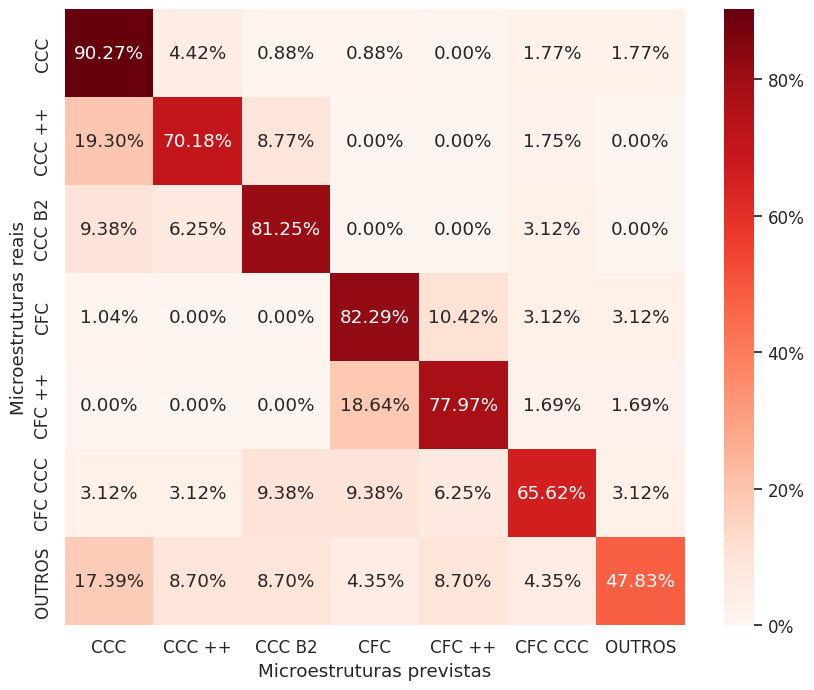

In [11]:
all_data_report = get_reports(x_train,y_train, DEFAULT_FOREST, filename='conjunto_dados_completo', title='Conjunto de dados completo')

###  5.2 Sem duplicados

======= Sem duplicdos ==========
 Modelo: RandomForestClassifier
acuracia: 0.6629213483146067
media f1 scores:  0.5995888746497793

 relatorio, n= (267, 27)

               precision    recall  f1-score     support
BCC            0.781609  0.906667  0.839506   75.000000
BCC ++         0.629630  0.459459  0.531250   37.000000
BCC B2         0.619048  0.565217  0.590909   23.000000
FCC            0.636364  0.552632  0.591549   38.000000
FCC ++         0.692308  0.658537  0.675000   41.000000
FCC BCC        0.530612  0.722222  0.611765   36.000000
OTHER          0.454545  0.294118  0.357143   17.000000
accuracy       0.662921  0.662921  0.662921    0.662921
macro avg      0.620588  0.594122  0.599589  267.000000
weighted avg   0.657494  0.662921  0.653404  267.000000 



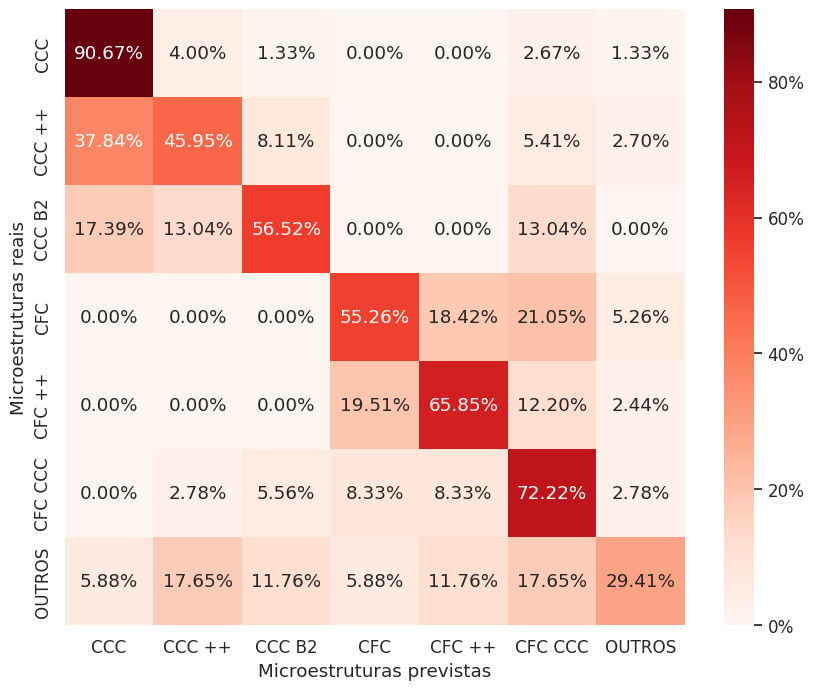

In [12]:
without_duplicate_report = get_reports(x_train_droped_duplicates, y_train_droped_duplicates, DEFAULT_FOREST, filename='sem_duplicados', title='Sem duplicdos')

### 5.3 conjunto de teste sem duplicados

======= Todas as propriedades (conjunto teste) ==========
 Modelo: RandomForestClassifier
acuracia: 0.6782608695652174
media f1 scores:  0.6278020853186697

 relatorio, n= (115, 27)

               precision    recall  f1-score     support
BCC            0.781250  0.781250  0.781250   32.000000
BCC ++         0.909091  0.689655  0.784314   29.000000
BCC B2         0.636364  0.875000  0.736842    8.000000
FCC            0.684211  0.541667  0.604651   24.000000
FCC ++         0.421053  0.666667  0.516129   12.000000
FCC BCC        0.333333  0.500000  0.400000    6.000000
OTHER          0.666667  0.500000  0.571429    4.000000
accuracy       0.678261  0.678261  0.678261    0.678261
macro avg      0.633138  0.650606  0.627802  115.000000
weighted avg   0.718216  0.678261  0.687224  115.000000 



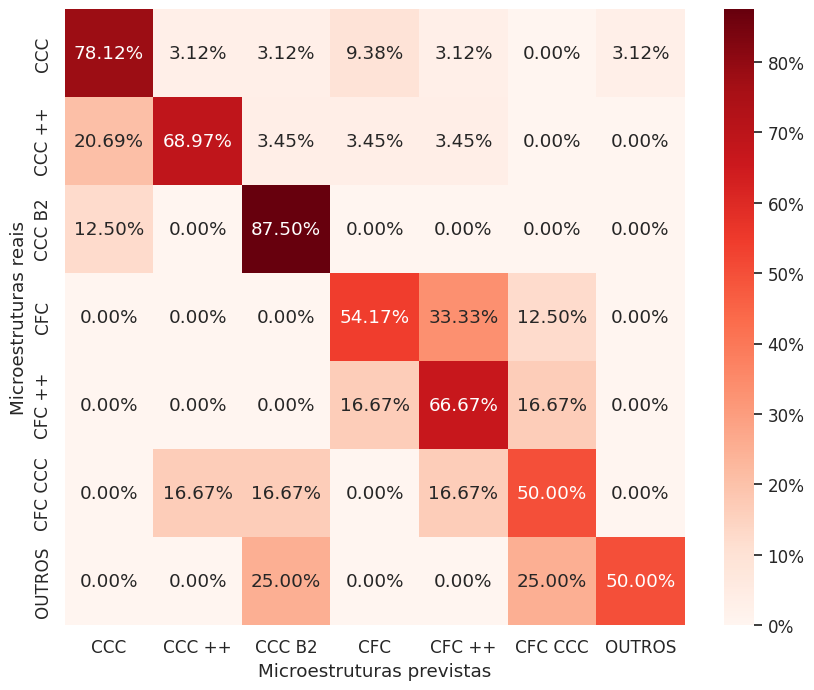

In [13]:
without_duplicate_report_test = get_reports(
    x_train_droped_duplicates, 
    y_train_droped_duplicates, 
    DEFAULT_FOREST, 
    display_cm= True, 
    title='Todas as propriedades (conjunto teste)', 
    filename='sem_feature_teste',
    validate=True,
    x_test=x_test_droped_duplicates, 
    y_test=y_test_droped_duplicates
    )

## 6.0 Filtro Feature Selection

### 6.1 Obtendo variáveis do Fetarue Selection e removendo as desnecessárias

In [14]:
nomes_propriedades = df.columns.difference(['PROPERTY: Microstructure'])

default_forest_fit = DEFAULT_FOREST.fit(
      x_train_droped_duplicates,
      y_train_droped_duplicates.values.reshape(-1,)
      )

# Treinando o modelo para selecionar as colunas
filter_model = SelectFromModel(default_forest_fit, prefit=True)

#converter o Dataframe de treino e teste e remover colunas desnecessárias
x_train_droped_duplicates_featured = filter_model.transform(x_train_droped_duplicates)

x_train_droped_duplicates_featured = \
  pd.DataFrame(x_train_droped_duplicates_featured, 
  columns=filter_model.get_feature_names_out(input_features=nomes_propriedades)
)

x_test_droped_duplicates_featured = filter_model.transform(x_test_droped_duplicates)

x_test_droped_duplicates_featured = \
  pd.DataFrame(x_test_droped_duplicates_featured, 
  columns=filter_model.get_feature_names_out(input_features=nomes_propriedades)
)

print(x_test_droped_duplicates_featured.columns) 

Index(['Cr', 'Fe', 'Ni', 'PROPERTY: Calculated Density (g/cm$^3$)',
       'PROPERTY: Processing method', 'Tm', 'Xm', 'am', 'dT', 'dX', 'da', 'dr',
       'rm'],
      dtype='object')


### 6.2 Varáveis utilizadas após o Feature selection

In [15]:
filter_model.get_feature_names_out(input_features=nomes_propriedades)

array(['Cr', 'Fe', 'Ni', 'PROPERTY: Calculated Density (g/cm$^3$)',
       'PROPERTY: Processing method', 'Tm', 'Xm', 'am', 'dT', 'dX', 'da',
       'dr', 'rm'], dtype=object)

### 6.3 Comparando o desempenho do modelo após Feature selection

#### 6.3.1. Comparando conjunto de treino com todos as propriedades vs conjunto de treino com Feature Selection

======= Todas as propriedades (conjunto treino) ==========
 Modelo: RandomForestClassifier
acuracia: 0.6629213483146067
media f1 scores:  0.5995888746497793

 relatorio, n= (267, 27)

               precision    recall  f1-score     support
BCC            0.781609  0.906667  0.839506   75.000000
BCC ++         0.629630  0.459459  0.531250   37.000000
BCC B2         0.619048  0.565217  0.590909   23.000000
FCC            0.636364  0.552632  0.591549   38.000000
FCC ++         0.692308  0.658537  0.675000   41.000000
FCC BCC        0.530612  0.722222  0.611765   36.000000
OTHER          0.454545  0.294118  0.357143   17.000000
accuracy       0.662921  0.662921  0.662921    0.662921
macro avg      0.620588  0.594122  0.599589  267.000000
weighted avg   0.657494  0.662921  0.653404  267.000000 

======= Com feture selection (conjunto treino) ==========
 Modelo: RandomForestClassifier
acuracia: 0.6554307116104869
media f1 scores:  0.5999153076637648

 relatorio, n= (267, 13)

              

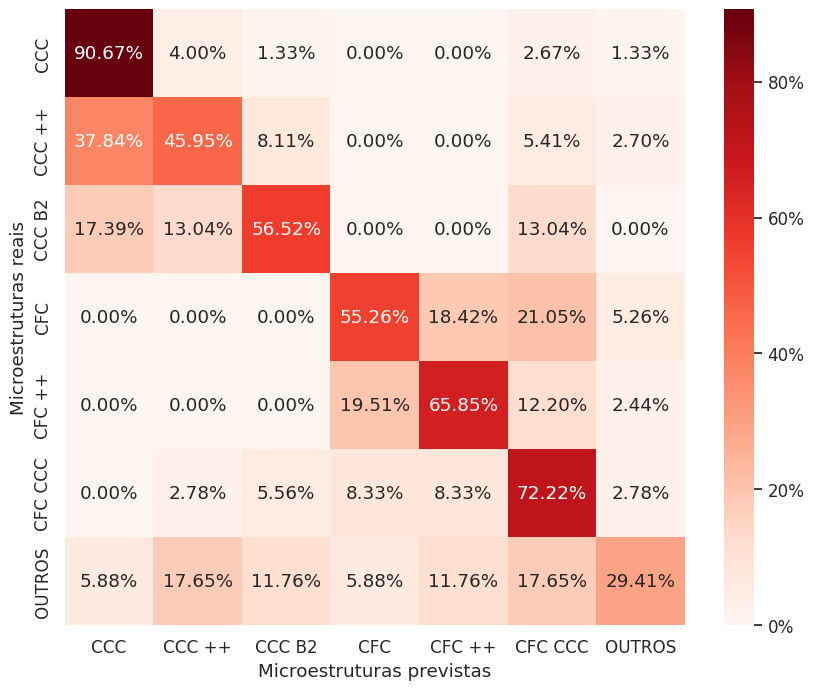

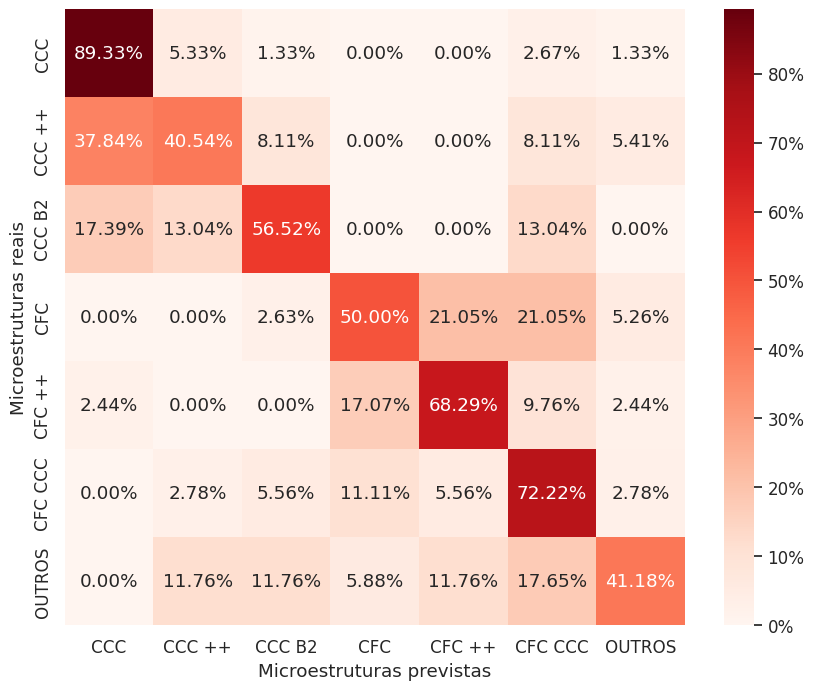

In [16]:
without_duplicate_report = get_reports(
    x_train_droped_duplicates, 
    y_train_droped_duplicates, 
    DEFAULT_FOREST, 
    display_cm= True, 
    title='Todas as propriedades (conjunto treino)', 
    filename='sem_feature_treino'
  )

feature_selection_report = get_reports(
    x_train_droped_duplicates_featured, 
    y_train_droped_duplicates, 
    DEFAULT_FOREST, 
    display_cm= True, 
    title='Com feture selection (conjunto treino)', 
    filename='com_feature_treino'
  )

#### 6.3.2. Comparando conjunto de teste com todos as propriedades vs conjunto de teste com Feature Selection

======= Todas as propriedades (conjunto teste) ==========
 Modelo: RandomForestClassifier
acuracia: 0.6782608695652174
media f1 scores:  0.6278020853186697

 relatorio, n= (115, 27)

               precision    recall  f1-score     support
BCC            0.781250  0.781250  0.781250   32.000000
BCC ++         0.909091  0.689655  0.784314   29.000000
BCC B2         0.636364  0.875000  0.736842    8.000000
FCC            0.684211  0.541667  0.604651   24.000000
FCC ++         0.421053  0.666667  0.516129   12.000000
FCC BCC        0.333333  0.500000  0.400000    6.000000
OTHER          0.666667  0.500000  0.571429    4.000000
accuracy       0.678261  0.678261  0.678261    0.678261
macro avg      0.633138  0.650606  0.627802  115.000000
weighted avg   0.718216  0.678261  0.687224  115.000000 

======= Com feture selection (conjunto teste) ==========
 Modelo: RandomForestClassifier
acuracia: 0.6782608695652174
media f1 scores:  0.6228624783246632

 relatorio, n= (115, 13)

               p

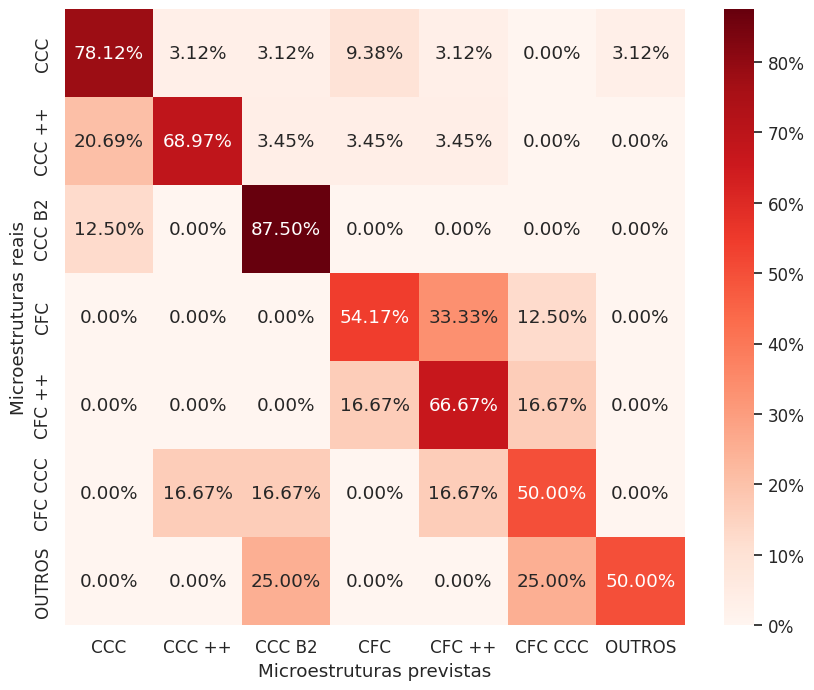

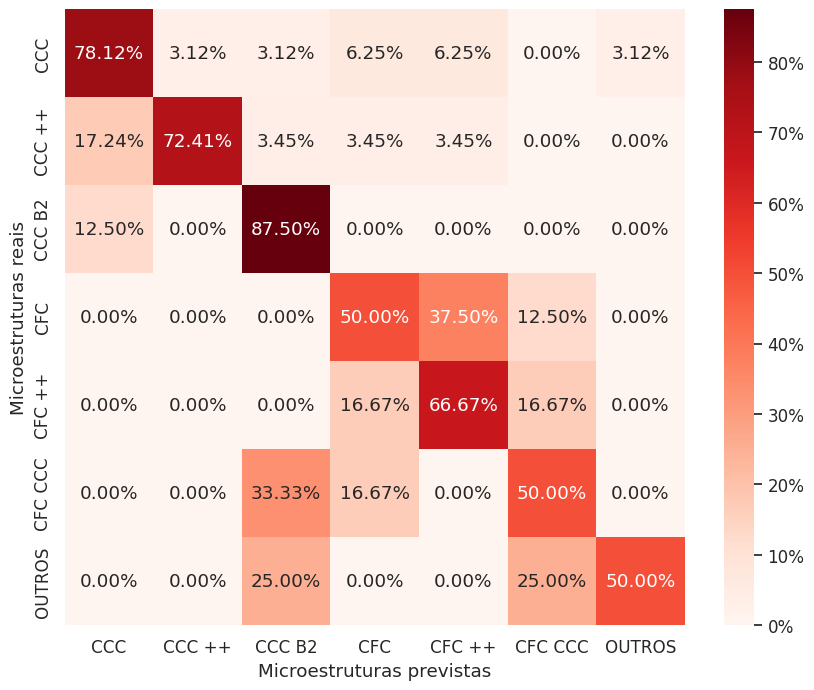

In [17]:
without_duplicate_report_test = get_reports(
    x_train_droped_duplicates, 
    y_train_droped_duplicates, 
    DEFAULT_FOREST, 
    display_cm= True, 
    title='Todas as propriedades (conjunto teste)', 
    filename='sem_feature_teste',
    validate=True,
    x_test=x_test_droped_duplicates, 
    y_test=y_test_droped_duplicates
    )

feature_selection_report_test = get_reports(
    x_train_droped_duplicates_featured, 
    y_train_droped_duplicates, 
    DEFAULT_FOREST,
    display_cm= True, 
    title='Com feture selection (conjunto teste)', 
    filename='com_feature_teste',
    validate=True,
    x_test=x_test_droped_duplicates_featured, 
    y_test=y_test_droped_duplicates
    )

### 6.4 Conclusão Feature selection
No conjunto de treino com todos os atributos, tivemos uma acurácia de 66,3% e um f1-score de 59,95%, no conjunto de treino após aplicar o feature selection e remover os atributos considerados redundantes, a acurácia reduziu para 65,5% e o f1-score se manteve o mesmo. Concluiu-se que com ou sem feature selection os valores de acurácia e f1 scores não se alteram significtivamente. Sendo assim é preferível manter todos os atributos originais do conjunto de dados para uma classificação de melhor qualidade.

## 7. Normalização dos dados




> As colunas que possuem variaveis categóricas convertidas em numéricas, não precisam ser normalizadas, umas vez que que os valores são equidistantes. 

> Colunas dos elementos quimicos possuem seus valores em porcentagem, neste caso também não podem ser normalizados, quando normalizados perdem seu real significado e valor.

> Apenas os dados sem duplicados serão normalizados, uma vez que já foi feita uma comparação no bloco anterior.


In [18]:
#----------------------------------------------------------------
# Normalizando os dados (sem feature Selection)
#----------------------------------------------------------------

# Variáveis que não serão normalizadas

not_normalize_list = [
  'Al','Co', 'Fe','Ni',	'Si','Cr','Mn','Nb',
  'Mo','Ti','Cu','V','Zr','Ta','Hf','W', 'PROPERTY: Processing method'
  ]

properties_to_not_normalize = properties_droped_duplicates[not_normalize_list]

columns_to_normalize = properties_droped_duplicates.columns.difference(
    not_normalize_list
)

properties_to_normalize = properties_droped_duplicates[columns_to_normalize]

properties_droped_duplicates_normalized = properties_to_not_normalize

for propertie in columns_to_normalize:
  std_properties = StandardScaler().fit(
      properties_to_normalize[propertie].values.reshape(-1,1)
  )


  normalized_properties = std_properties.transform(
      properties_to_normalize[propertie].values.reshape(-1,1)
  )

  properties_droped_duplicates_normalized = pd.concat(
      [
        properties_droped_duplicates_normalized,
        pd.DataFrame(normalized_properties, columns=[propertie])
      ], 
      axis=1
  )

df_properties_droped_duplicates_normalized = pd.concat(
    (properties_droped_duplicates_normalized,
    microstructure_droped_duplicates),
    axis=1
    )

x_train_normalized, x_test_normalized, y_train_normalized, y_test_normalized = \
  train_test_split(
    properties_droped_duplicates_normalized,
    microstructure_droped_duplicates,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE   
    )

x_train_normalized.reset_index(inplace=True)
x_train_normalized.drop(['index',],axis=1, inplace=True)
x_test_normalized.reset_index(inplace=True)
x_test_normalized.drop(['index',],axis=1, inplace=True)
y_train_normalized.reset_index(inplace=True)
y_train_normalized.drop(['index'],axis=1, inplace=True)
y_test_normalized.reset_index(inplace=True)
y_test_normalized.drop(['index'],axis=1, inplace=True)

### 7.2 Verificando influência da normalização no conjunto de dados

======= Todas as propriedades (conjunto treino) ==========
 Modelo: RandomForestClassifier
acuracia: 0.6629213483146067
media f1 scores:  0.5995888746497793

 relatorio, n= (267, 27)

               precision    recall  f1-score     support
BCC            0.781609  0.906667  0.839506   75.000000
BCC ++         0.629630  0.459459  0.531250   37.000000
BCC B2         0.619048  0.565217  0.590909   23.000000
FCC            0.636364  0.552632  0.591549   38.000000
FCC ++         0.692308  0.658537  0.675000   41.000000
FCC BCC        0.530612  0.722222  0.611765   36.000000
OTHER          0.454545  0.294118  0.357143   17.000000
accuracy       0.662921  0.662921  0.662921    0.662921
macro avg      0.620588  0.594122  0.599589  267.000000
weighted avg   0.657494  0.662921  0.653404  267.000000 

======= Dados normalizados (conjunto treino) ==========
 Modelo: RandomForestClassifier
acuracia: 0.6704119850187266
media f1 scores:  0.6184024213032336

 relatorio, n= (267, 27)

               p

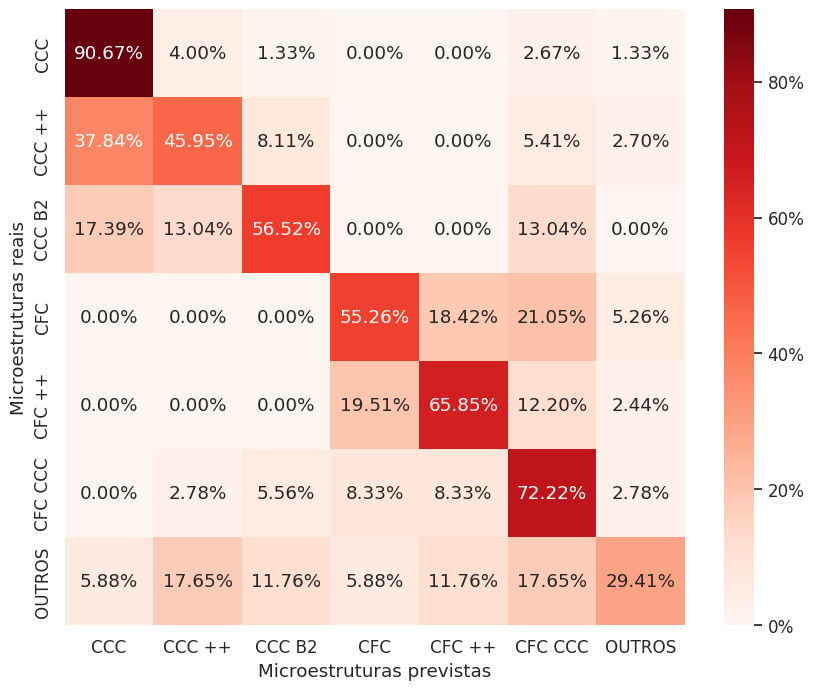

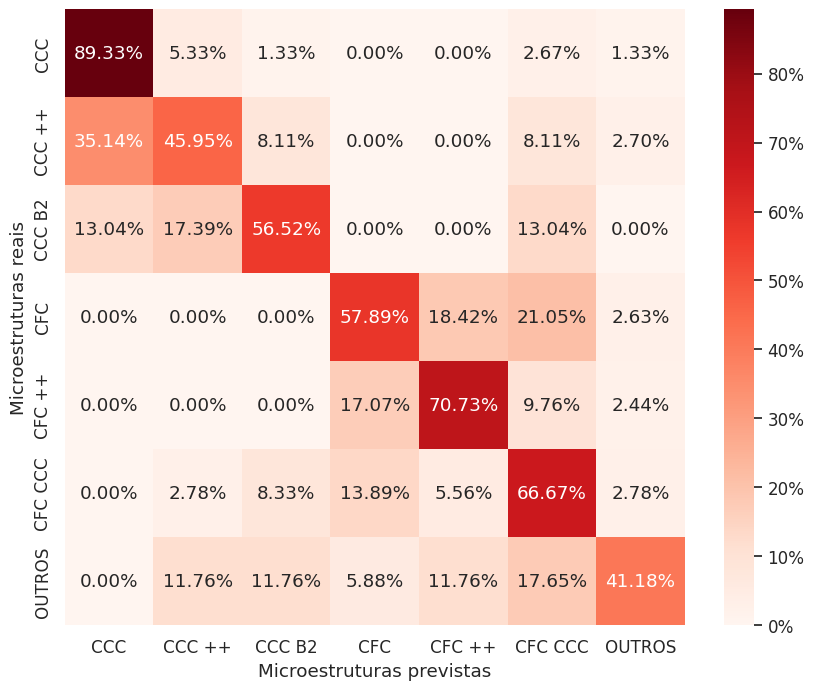

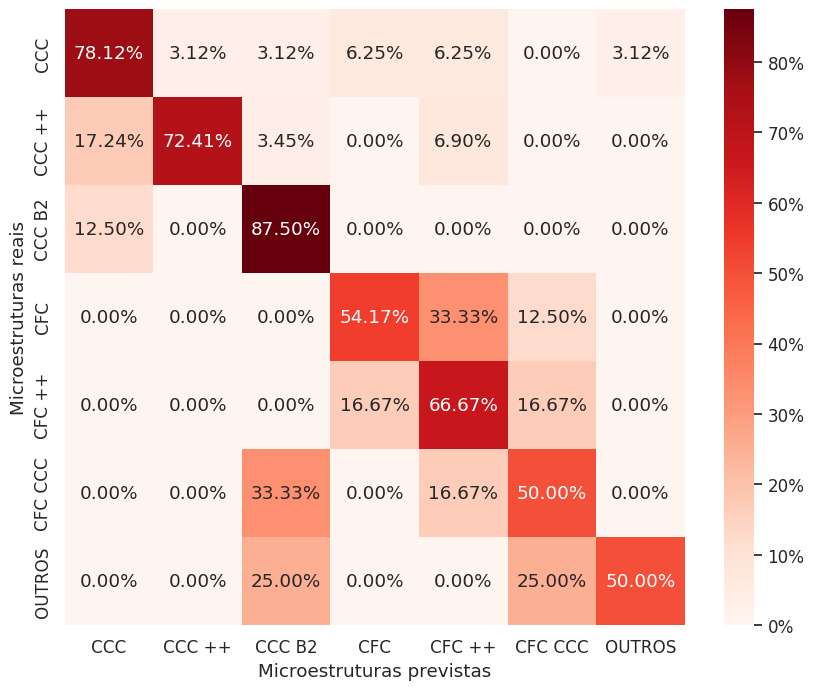

In [19]:

without_duplicate_report = get_reports(
    x_train_droped_duplicates, 
    y_train_droped_duplicates, 
    DEFAULT_FOREST, 
    display_cm= True, 
    title='Todas as propriedades (conjunto treino)', 
    filename='sem_feature_treino'
  )


without_duplicate_report_train = get_reports(
    x_train_normalized, 
    y_train_normalized, 
    DEFAULT_FOREST,
    display_cm= True, 
    title='Dados normalizados (conjunto treino)', 
    filename='dados_normalizados_treino'
    )

without_duplicate_report_test = get_reports(
    x_train_normalized, 
    y_train_normalized, 
    DEFAULT_FOREST, 
    display_cm= True, 
    title='Dados normalizados (conjunto teste)', 
    filename='dados_normalizados_teste',
    validate=True,
    x_test=x_test_normalized, 
    y_test=y_test_droped_duplicates
    )


## Conclusão Normalização

Ocorreu um aumento leve na acurácia do modelo de 59% para 61%

## 8. Comparando diferentes modelos

Nessa etapa são instanciados diversos modelos diferentes, e são comparados quais modelos performam melhor, serão avaliados os conjuntos de treino e teste.

### 8.1 Avaliação utilizando conjunto de treino e teste

modelo                         acuracia                       f1 scores
RandomForestClassifier
======= Resultados para o modelo RandomForestClassifier ==========
 Modelo: RandomForestClassifier
acuracia: 0.6704119850187266
media f1 scores:  0.6184024213032336

 relatorio, n= (267, 27)

               precision    recall  f1-score     support
BCC            0.807229  0.893333  0.848101   75.000000
BCC ++         0.607143  0.459459  0.523077   37.000000
BCC B2         0.590909  0.565217  0.577778   23.000000
FCC            0.628571  0.578947  0.602740   38.000000
FCC ++         0.725000  0.707317  0.716049   41.000000
FCC BCC        0.510638  0.666667  0.578313   36.000000
OTHER          0.583333  0.411765  0.482759   17.000000
accuracy       0.670412  0.670412  0.670412    0.670412
macro avg      0.636118  0.611815  0.618402  267.000000
weighted avg   0.668568  0.670412  0.664939  267.000000 

======= Dados normalizados (conjunto teste) ==========
 Modelo: RandomForestClassifier
acuraci

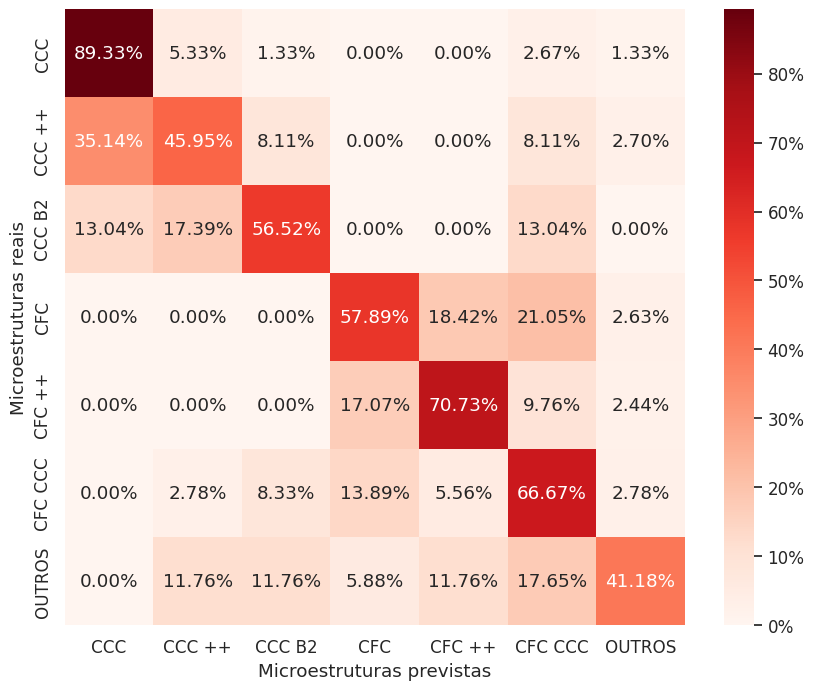

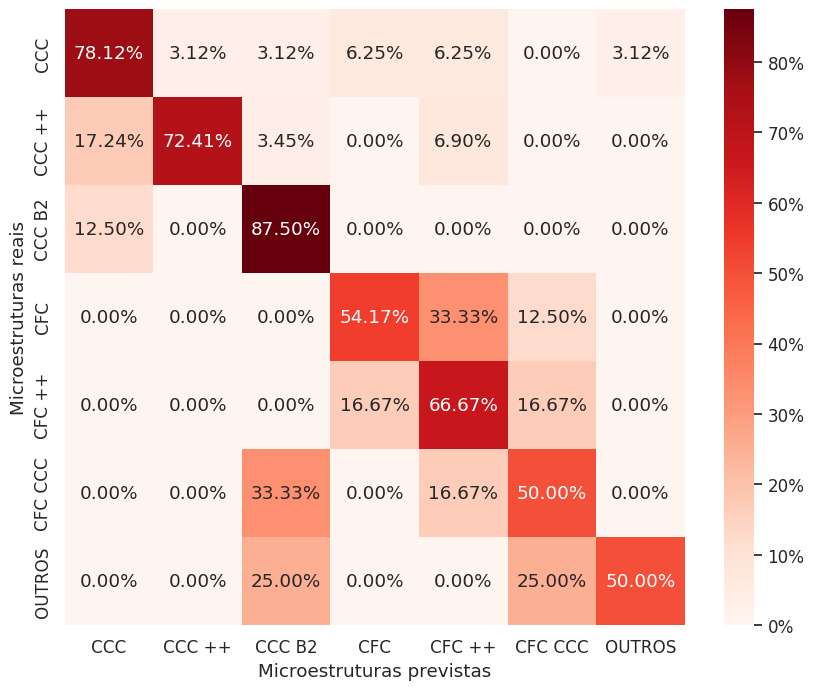

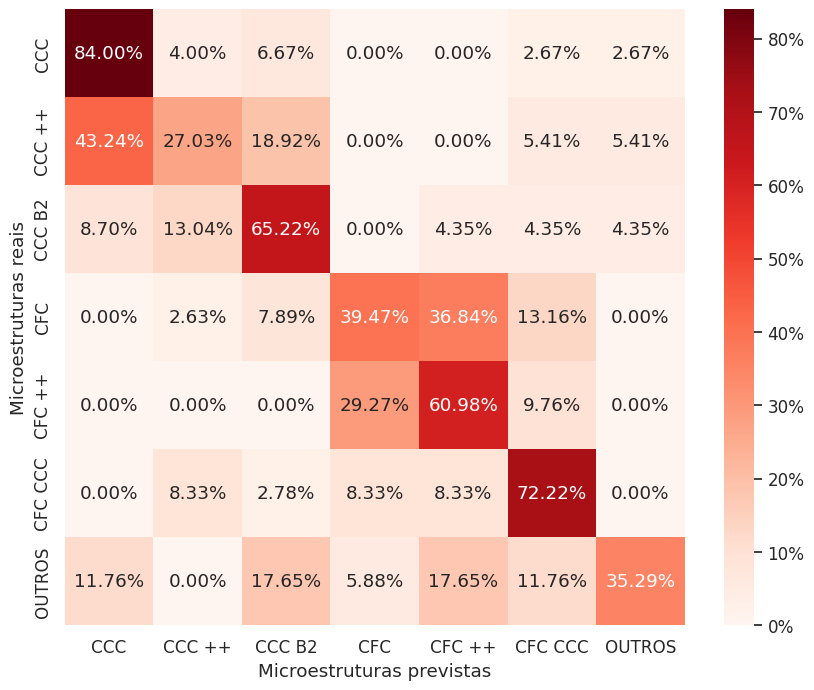

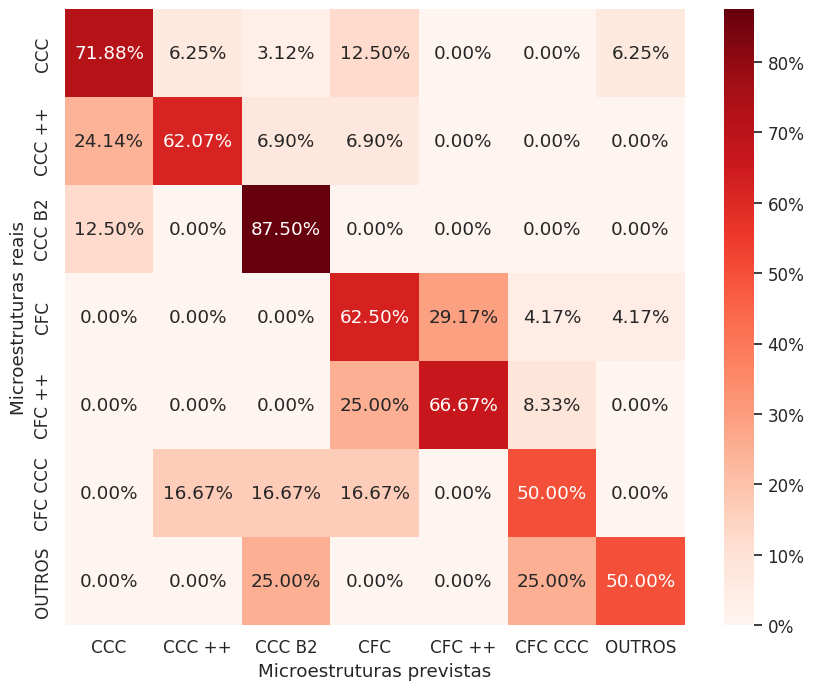

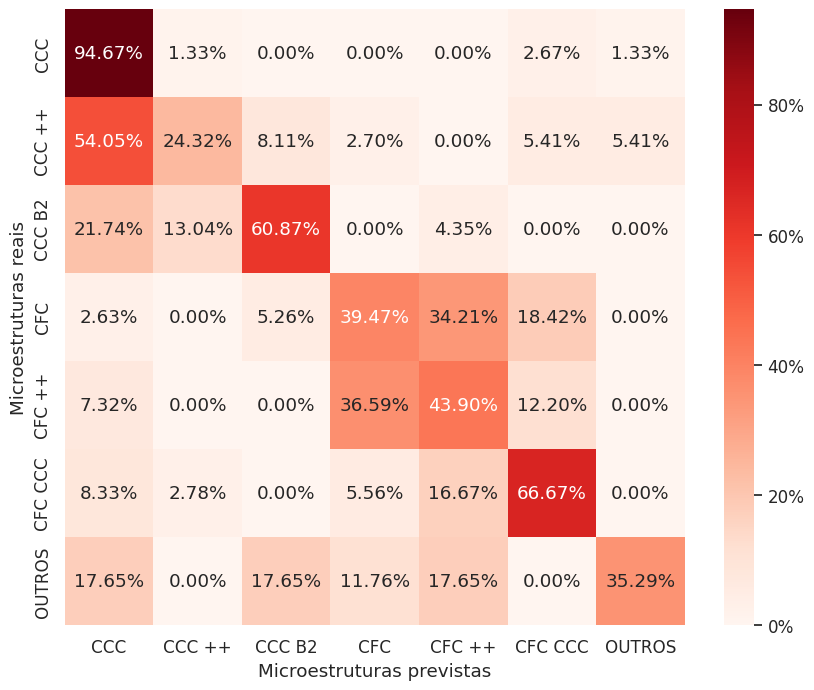

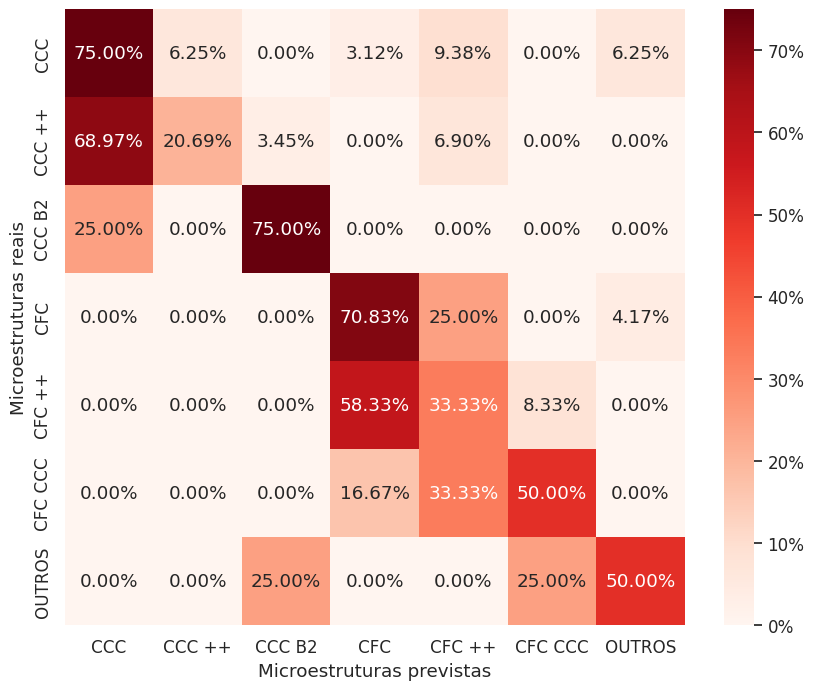

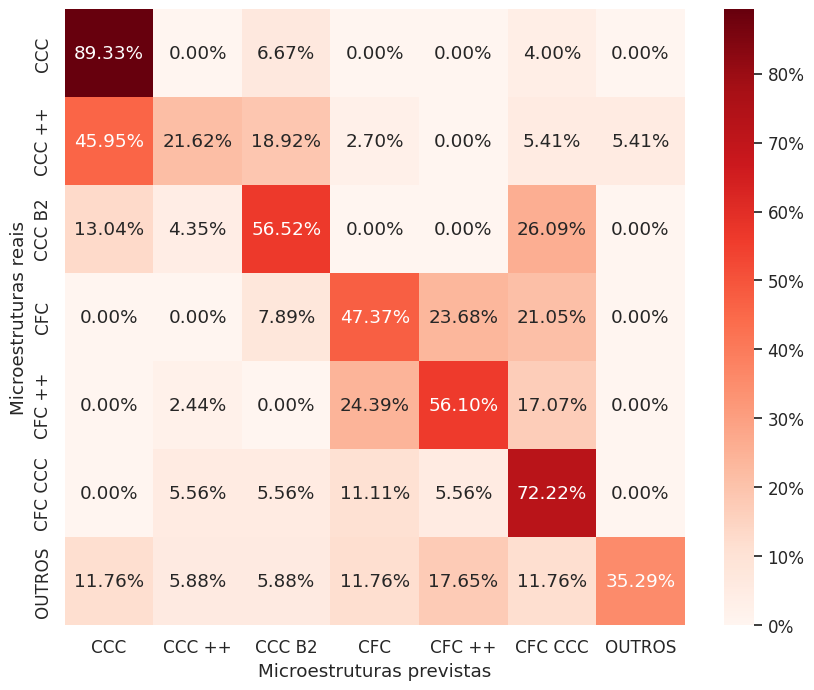

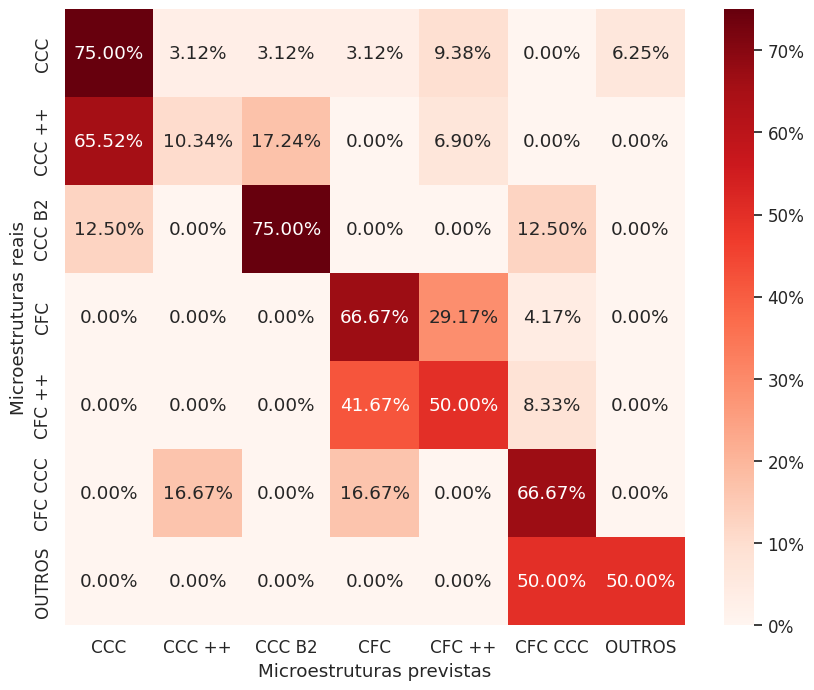

In [20]:
forest = RandomForestClassifier(random_state=54)
mlp = MLPClassifier(random_state=54)
knn = KNeighborsClassifier()
svm = SVC(random_state=54)

models= [
  forest, 
  mlp, 
  knn, 
  svm
]

cm_microstructure_models = {}

print("{0:30} {1:30} {2}".format('modelo', 
                                  'acuracia', 
                                  'f1 scores'))

for model in models:
  print(str(model.__class__.__name__))

  without_duplicate_report_train = get_reports(
      x_train_normalized, 
      y_train_normalized, 
      model, 
      display_cm= True, 
      title=f'Resultados para o modelo {str(model.__class__.__name__)}', 
      filename=f'{str(model.__class__.__name__)}_treino'
      )

  without_duplicate_report_test = get_reports(
      x_train_normalized, 
      y_train_normalized, 
      model, 
      display_cm= True, 
      title='Dados normalizados (conjunto teste)', 
      filename=f'{str(model.__class__.__name__)}_teste',
      validate=True,
      x_test=x_test_normalized, 
      y_test=y_test_droped_duplicates
      )

### 8.2 Conclusão avaliação dos modelos

Após avaliar o desempenho de diferentes modelos para o conjunto de dados sem duplicados, verificou-se a melhor performance do modelo radom forest, baseado na analise conjunta da acuracia, com f1 score.

## 9. Criando sobreamostragem 



> Essa etapa se baseia na utilização de modelos para gerar novos dados para treinamento do modelo, de forma que possibilite uma dispersão dos dados, tornando o modelo mais genérico e reduzindo o overffiting do ajuste da curva.






### 9.1 Resultados da redistribuição dos dados após a sobreamostragem

In [21]:
samplers = [
    SMOTE(random_state=RANDOM_STATE),
    ADASYN(random_state=RANDOM_STATE),
    BorderlineSMOTE(random_state=RANDOM_STATE),
    KMeansSMOTE(random_state=RANDOM_STATE),
    SVMSMOTE(random_state=RANDOM_STATE),
]

data_oversampled = {}

frequencia_treino = y_train_normalized['PROPERTY: Microstructure'].value_counts()
percentual_treino = y_train_normalized['PROPERTY: Microstructure'].value_counts(normalize = True)*100

print('distribuição dos dados nao sobreamostrados')
dist_freq_qualitativas = pd.DataFrame({'Qtd': frequencia_treino, 
                                        '(%)': percentual_treino})



dist_freq_qualitativas.rename(index = {
    0.0: 'CCC', 
    1.0: 'CCC++',
    2.0: 'CCC B2',
    3.0: 'CFC',
    4.0: 'CFC++',
    5.0: 'CFC CCC',
    6.0: 'Outros'}, inplace = True)

print(dist_freq_qualitativas)

for sampler in samplers:

  properties_train_oversampled, microstructure_train_oversampled = \
    sampler.fit_resample(x_train_normalized, 
    y_train_normalized.values.reshape(-1,)
    )

  properties_train_oversampled = pd.DataFrame(
      properties_train_oversampled, 
      columns=x_train_normalized.columns
    )

  microstructure_train_oversampled = pd.DataFrame(
      microstructure_train_oversampled, 
      columns=['PROPERTY: Microstructure']
    )

  data_oversampled[str(sampler.__class__.__name__)] = {
      'properties_train_oversampled': properties_train_oversampled,
      'microstructure_train_oversampled': microstructure_train_oversampled 
    }

  frequencia_treino = microstructure_train_oversampled['PROPERTY: Microstructure'].value_counts()
  percentual_treino = microstructure_train_oversampled['PROPERTY: Microstructure'].value_counts(normalize = True)*100

  print(f'distribuição dos dados {str(sampler.__class__.__name__)}')
  dist_freq_qualitativas = pd.DataFrame({'Qtd': frequencia_treino, 
                                         '(%)': percentual_treino})
  
  
  
  dist_freq_qualitativas.rename(index = {
      0.0: 'CCC', 
      1.0: 'CCC++',
      2.0: 'CCC B2',
      3.0: 'CFC',
      4.0: 'CFC++',
      5.0: 'CFC CCC',
      6.0: 'Outros'}, inplace = True)

  print(dist_freq_qualitativas)

distribuição dos dados nao sobreamostrados
         Qtd        (%)
CCC       75  28.089888
CFC++     41  15.355805
CFC       38  14.232210
CCC++     37  13.857678
CFC CCC   36  13.483146
CCC B2    23   8.614232
Outros    17   6.367041
distribuição dos dados SMOTE
         Qtd        (%)
CCC       75  14.285714
CFC CCC   75  14.285714
CFC       75  14.285714
CCC B2    75  14.285714
CCC++     75  14.285714
CFC++     75  14.285714
Outros    75  14.285714
distribuição dos dados ADASYN
         Qtd        (%)
CFC CCC   82  15.384615
CFC       79  14.821764
CCC B2    78  14.634146
CCC       75  14.071295
Outros    75  14.071295
CFC++     73  13.696060
CCC++     71  13.320826
distribuição dos dados BorderlineSMOTE
         Qtd        (%)
CCC       75  14.285714
CFC CCC   75  14.285714
CFC       75  14.285714
CCC B2    75  14.285714
CCC++     75  14.285714
CFC++     75  14.285714
Outros    75  14.285714
distribuição dos dados KMeansSMOTE
         Qtd        (%)
CCC++     78  14.606742
CFC CCC 

In [22]:
microstructure_train_oversampled.shape

(478, 1)

### 9.2 Verificando o desempenho dos diferentes tipos de sobre amostragem (TREINO)
> Através do cross validation, será verificado o comportamento dos diferentes tipos de modelos de sobre amostragem, utilizando apenas o classificador random forest.

======= Resultados para a sobreamostragem: SMOTE ==========
 Modelo: RandomForestClassifier
acuracia: 0.8
media f1 scores:  0.8002661153194557

 relatorio, n= (525, 27)

               precision    recall  f1-score  support
BCC            0.784810  0.826667  0.805195     75.0
BCC ++         0.828125  0.706667  0.762590     75.0
BCC B2         0.784810  0.826667  0.805195     75.0
FCC            0.794521  0.773333  0.783784     75.0
FCC ++         0.887324  0.840000  0.863014     75.0
FCC BCC        0.707865  0.840000  0.768293     75.0
OTHER          0.842857  0.786667  0.813793     75.0
accuracy       0.800000  0.800000  0.800000      0.8
macro avg      0.804330  0.800000  0.800266    525.0
weighted avg   0.804330  0.800000  0.800266    525.0 

======= Resultados para a sobreamostragem: ADASYN ==========
 Modelo: RandomForestClassifier
acuracia: 0.7898686679174484
media f1 scores:  0.7902566805199681

 relatorio, n= (533, 27)

               precision    recall  f1-score     support
B

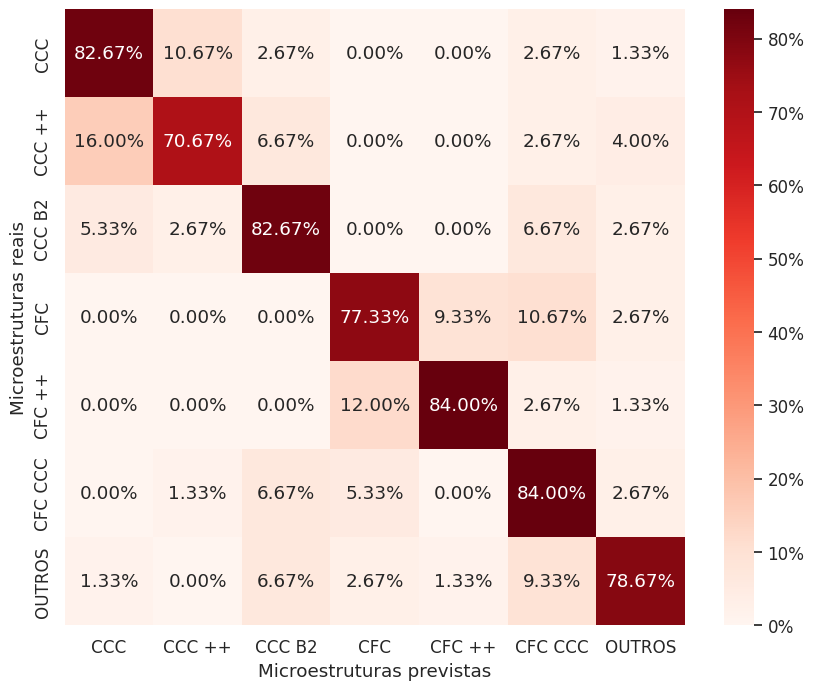

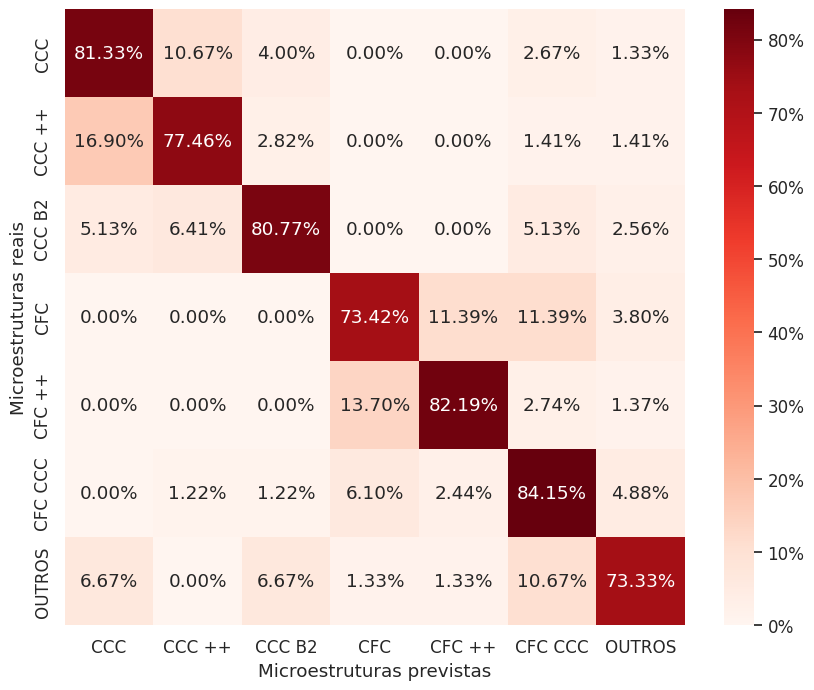

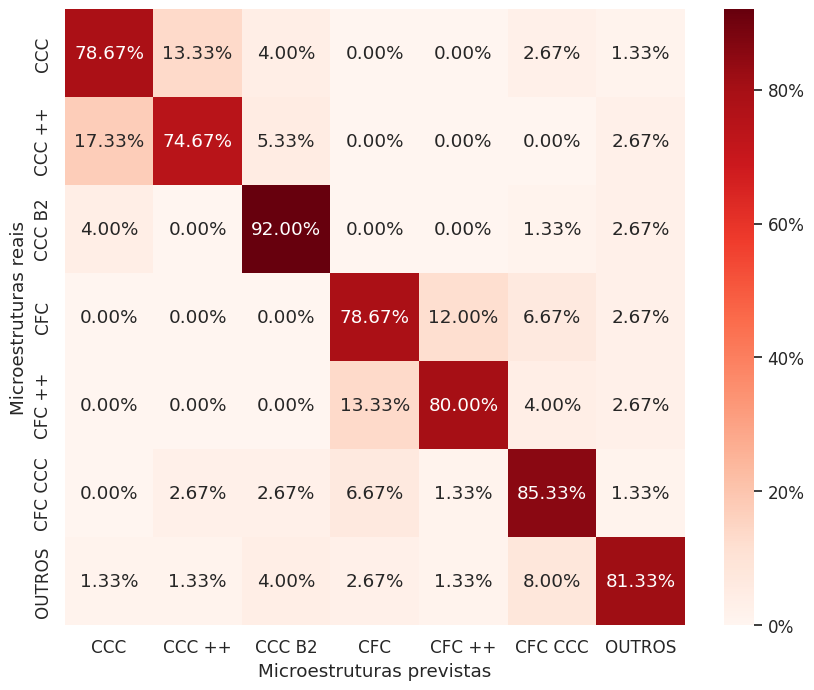

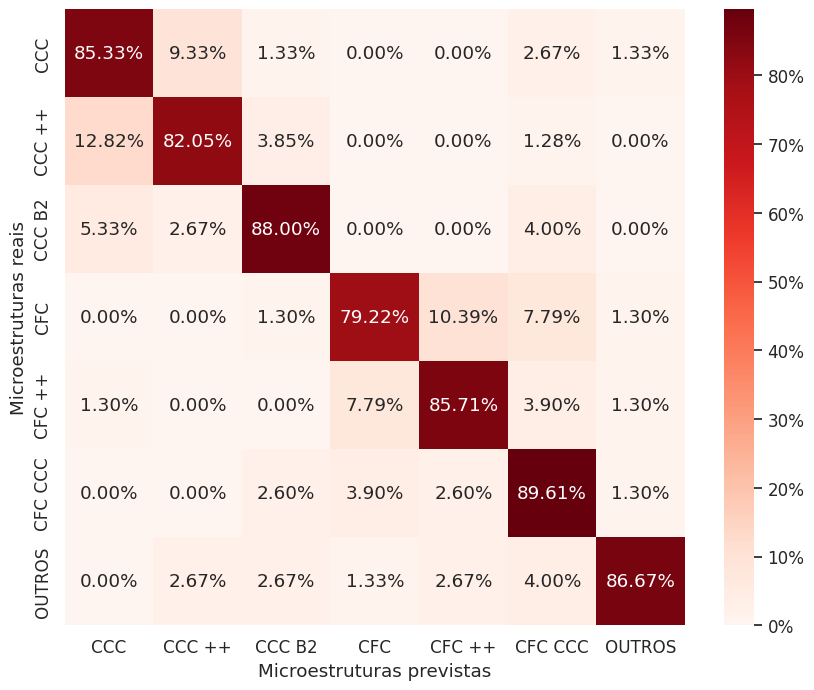

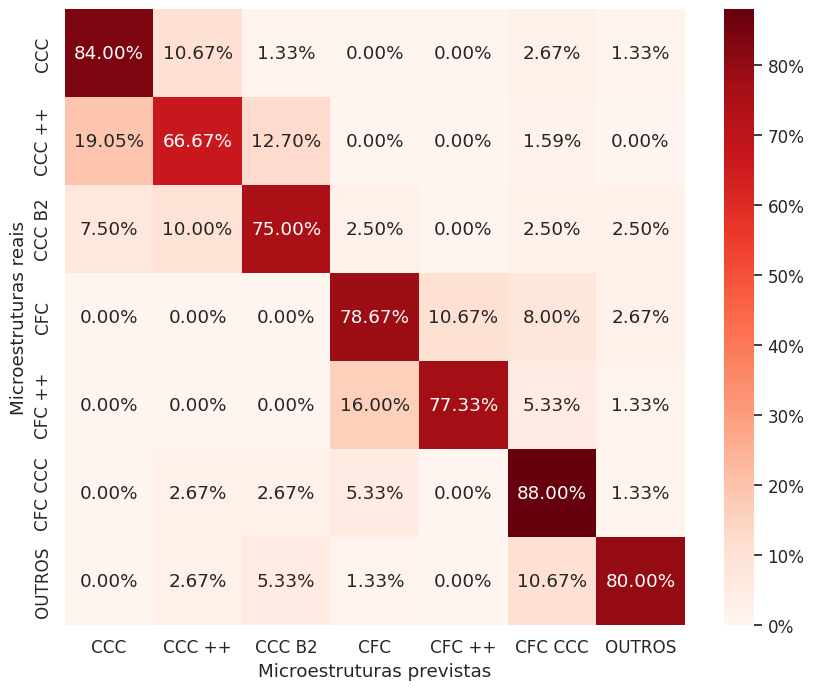

In [23]:

for oversampled in data_oversampled.keys():

  without_duplicate_report_train = get_reports(
      data_oversampled[oversampled]['properties_train_oversampled'], 
      data_oversampled[oversampled]['microstructure_train_oversampled'],
      DEFAULT_FOREST, 
      display_cm= True, 
      title=f'Resultados para a sobreamostragem: {str(oversampled)}', 
      filename=f'{str(oversampled)}_treino'
      )
  

### 9.3 Verificando o desempenho dos diferentes tipos de sobre amostragem (TESTE)
> Através do cross validation, será verificado o comportamento dos diferentes tipos de modelos de sobre amostragem, utilizando apenas o classificador random forest.

======= Resultados para a sobreamostragem: SMOTE ==========
 Modelo: RandomForestClassifier
acuracia: 0.7217391304347827
media f1 scores:  0.6851686911323669

 relatorio, n= (115, 27)

               precision    recall  f1-score     support
BCC            0.833333  0.781250  0.806452   32.000000
BCC ++         1.000000  0.758621  0.862745   29.000000
BCC B2         0.700000  0.875000  0.777778    8.000000
FCC            0.619048  0.541667  0.577778   24.000000
FCC ++         0.500000  0.750000  0.600000   12.000000
FCC BCC        0.500000  0.666667  0.571429    6.000000
OTHER          0.500000  0.750000  0.600000    4.000000
accuracy       0.721739  0.721739  0.721739    0.721739
macro avg      0.664626  0.731886  0.685169  115.000000
weighted avg   0.757598  0.721739  0.729944  115.000000 

======= Resultados para a sobreamostragem: ADASYN ==========
 Modelo: RandomForestClassifier
acuracia: 0.7304347826086957
media f1 scores:  0.7118905480196639

 relatorio, n= (115, 27)

          

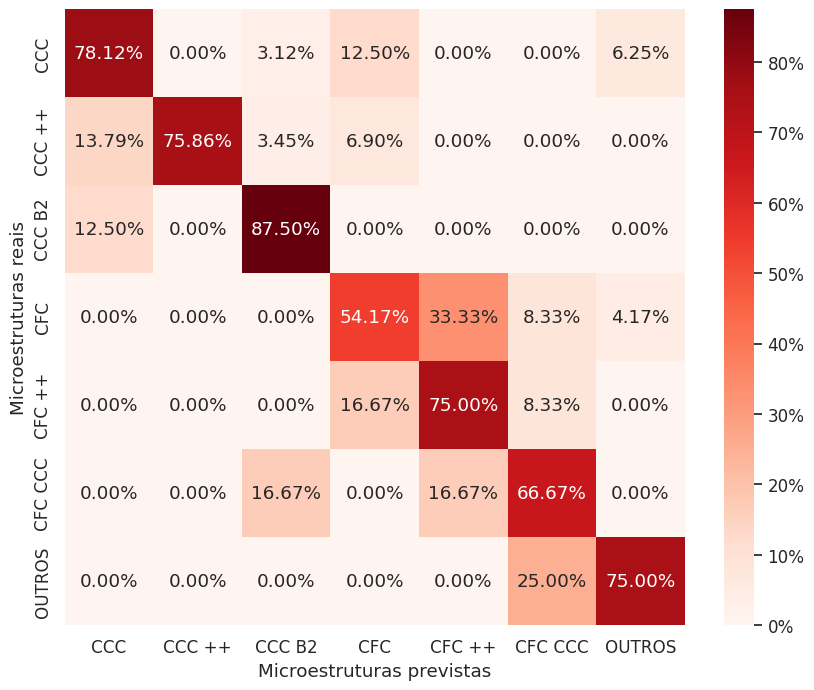

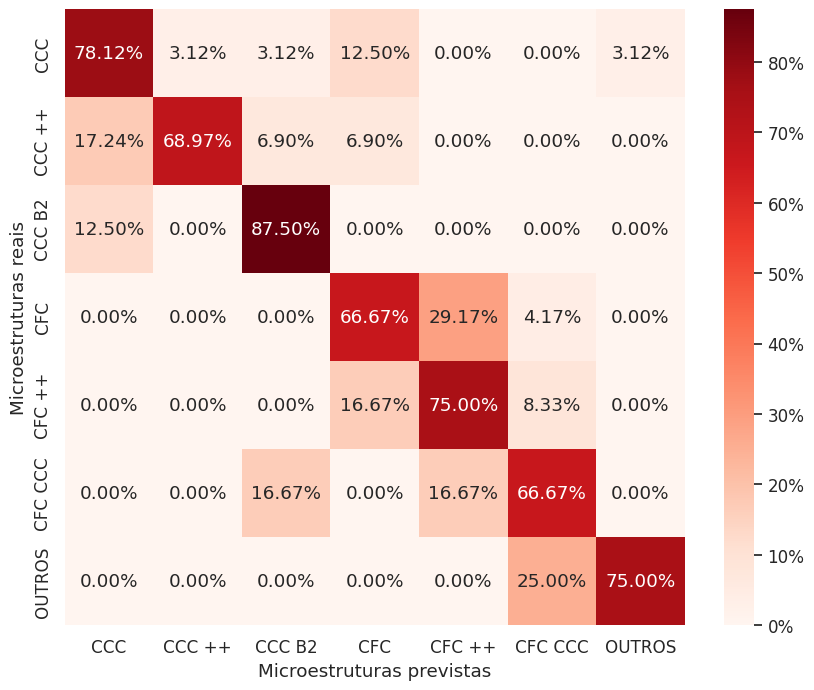

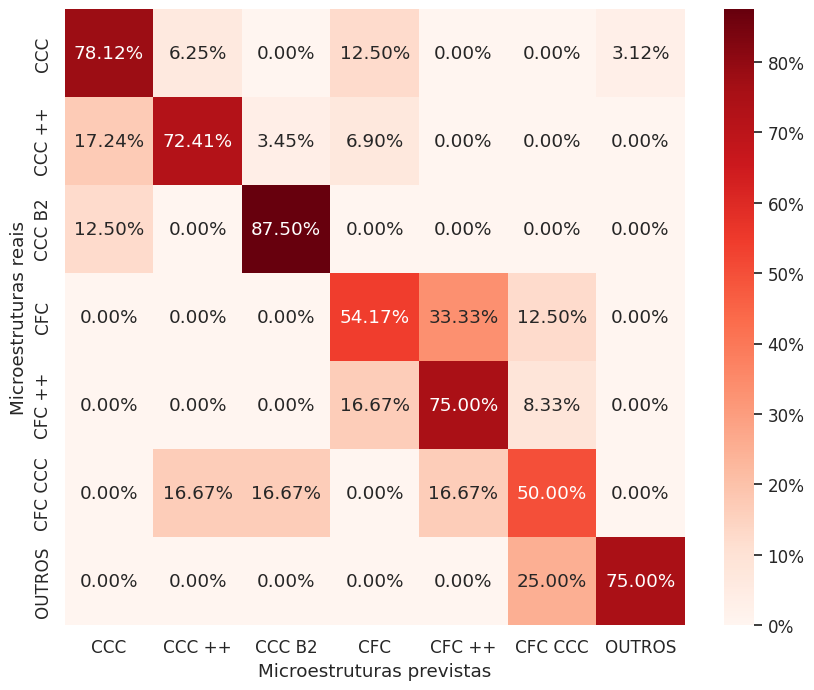

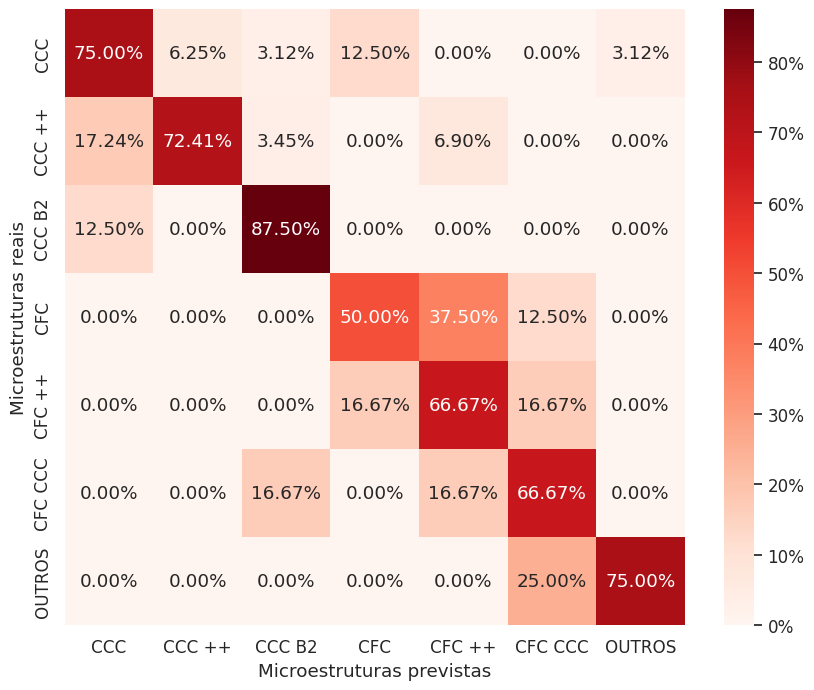

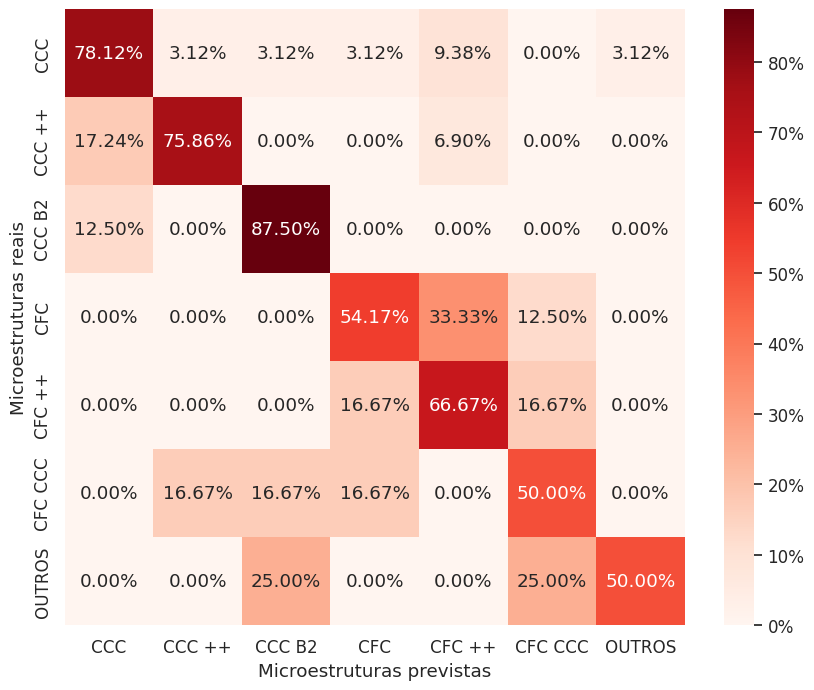

In [24]:
for oversampled in data_oversampled.keys():

  get_reports(
      data_oversampled[oversampled]['properties_train_oversampled'], 
      data_oversampled[oversampled]['microstructure_train_oversampled'],
      DEFAULT_FOREST, 
      display_cm= True, 
      title=f'Resultados para a sobreamostragem: {str(oversampled)}', 
      filename=f'{str(oversampled)}_teste',
      validate=True,
      x_test=x_test_normalized, 
      y_test=y_test_droped_duplicates
      )


### 8.2.3 Conclusão comparação de modelos e sobreamostragens

Após a avaliação dos modelos em conjunto com o tipo de sobreamostragem, analisando a aplicação de diferentes modelos de sobreamostragem tanto no conjunto de treino e conjunto de teste, o modelo que apresentou melhores resultados no conjunto de treino foi o modelo KMeansSmote, porem no conjunto de teste o mesmo não foi tão performatico. O modelo que melhor apresentou resultado no conjunto de teste foi o SMOTE.

Sendo assim, a próxima etapa será analizar a melhor combinação de hiperparâmetros.

In [25]:
best_oversampled = 'SMOTE'

## 9 Avaliando hiperparâmetros dos modelos

Nesta etapa, serão avaliados os melhores hiperparâmetros para o modelo RandoForest, considerando os dados sobre amostrados, e os dados originais sem duplicados e normalizados.

### 9.2 Otimizando hiperparâmetros dos dados sobreamostrados

In [26]:
parameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [21,22,23,24,190,195,200],
    'max_depth': [6,7,9,11,12,13,14,15],
    'max_features': ['auto']
}

regressor = GridSearchCV(RandomForestClassifier(random_state=54), parameters, verbose=1,cv=10,n_jobs=-1) 


regressor.fit(data_oversampled[best_oversampled]['properties_train_oversampled'].to_numpy(), 
      data_oversampled[best_oversampled]['microstructure_train_oversampled'].to_numpy()) 

  # print(oversampled)
print(regressor.best_params_)
# regressor.best_params_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
{'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 190}



# Definindo range de hiperparâmetros que serão utilizados

In [27]:
# number of trees in random forest

from time import time

tempo1= time()

n_estimators = [x for x in range(200,400,50)]
n_estimators.append(None)

criterion = ['entropy', 'gini']

# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]

# Maximum number of levels in tree
max_depth = [10]#[x for x in range(1,11,2)]
max_depth.append(None)


# Minimum number of samples required to split a node
# min_samples_split = [1,2, 5]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1]

# Method of selecting samples of training each tree
# bootstrap = [True, False]

parameters ={
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_features': max_features,
    'max_depth': max_depth,
    # 'min_samples_leaf': min_samples_leaf,
    # 'min_samples_split': min_samples_split
    
}

oversampled = 'SMOTE'

regressor = GridSearchCV(RandomForestClassifier(random_state=54), parameters, verbose=1,cv=10,n_jobs=-1) 

# for oversampled in oversamplers:

regressor.fit(data_oversampled[best_oversampled]['properties_train_oversampled'].to_numpy(), 
      data_oversampled[best_oversampled]['microstructure_train_oversampled'].to_numpy()) 

  # print(oversampled)
print(regressor.best_params_)

tempo2 = time() - tempo1

print(f' {tempo2/60} min')
# regressor.best_params_

Fitting 10 folds for each of 60 candidates, totalling 600 fits
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 350}
 4.850625256697337 min


###8.2.4 Histórico de busca por melhores parametros

In [28]:
# Fitting 10 folds for each of 40 candidates, totalling 400 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [11, 12, 13, 14, 15],
#                          'max_features': ['auto'],
#                          'n_estimators': [21, 22, 23, 24]},
#              verbose=1)

# Fitting 10 folds for each of 24 candidates, totalling 240 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [11, 12, 13, 15],
#                          'max_features': ['auto'],
#                          'n_estimators': [20, 23, 24]},
#              verbose=1)

# Fitting 10 folds for each of 24 candidates, totalling 240 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [12, 15, 17], 'max_features': ['auto'],
#                          'n_estimators': [12, 15, 20, 23]},
#              verbose=1)

# Fitting 10 folds for each of 70 candidates, totalling 700 fits
# GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=54),
#              n_jobs=-1,
#              param_grid={'criterion': ['entropy', 'gini'],
#                          'max_depth': [6, 10, 12, 15, 18],
#                          'max_features': ['auto'],
#                          'n_estimators': [1, 10, 20, 25, 30, 50, 60]},
#              verbose=1)


Uma vez que os hiperparâmetros foram otimizados, é realizada a etapa para verificar o comportamento do modelo em conjuntos de dados simulados com composições variaveis

### 9.2.1 Avaliando hiperparâmetros através do cross validation 

In [30]:
from time import time

argumentos = [
    {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 8},
    {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 61},
    {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2',  'n_estimators': 110},
    {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150},
    {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 190},
    {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 250},
    {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 450}
]


hiperparameter_adjusted_forest = [
    RandomForestClassifier(
      random_state=54,
      criterion=arg['criterion'],
      max_depth=arg['max_depth'],
      max_features=arg['max_features'],
      n_estimators=arg['n_estimators']
    )
    for arg in argumentos
] 


for i,forest in enumerate(hiperparameter_adjusted_forest):
  start_time = time()


  get_reports(
      data_oversampled[best_oversampled]['properties_train_oversampled'], 
      data_oversampled[best_oversampled]['microstructure_train_oversampled'],
      forest, 
      display_cm=False, 
      title=f'Resultados dos hiper parametros ajustados: Forest {i+1}', 
      filename=f'random_forest_adjusted_{i+1}_treino',
      report=None
      )
  
  get_reports(
        data_oversampled[best_oversampled]['properties_train_oversampled'], 
        data_oversampled[best_oversampled]['microstructure_train_oversampled'],
        forest, 
        display_cm=False, 
        title=f'Resultados dos hiper parametros ajustados: Forest {i+1} teste', 
        filename=f'random_forest_adjusted_{i+1}_teste',
        validate=True,
        x_test=x_test_normalized, 
        y_test=y_test_droped_duplicates,
        report=None
        )

  end_time = time() - start_time

  print (f'\n \n Tempo de execução {end_time} s \n \n')
  

======= Resultados dos hiper parametros ajustados: Forest 1 ==========
 Modelo: RandomForestClassifier
acuracia: 0.8019047619047619
media f1 scores:  0.8014233449281912
======= Resultados dos hiper parametros ajustados: Forest 1 teste ==========
 Modelo: RandomForestClassifier
acuracia: 0.6521739130434783
media f1 scores:  0.6312502188649447

 
 Tempo de execução 0.3584012985229492 s 
 

======= Resultados dos hiper parametros ajustados: Forest 2 ==========
 Modelo: RandomForestClassifier
acuracia: 0.8171428571428572
media f1 scores:  0.8166241816082086
======= Resultados dos hiper parametros ajustados: Forest 2 teste ==========
 Modelo: RandomForestClassifier
acuracia: 0.7217391304347827
media f1 scores:  0.6877232784193735

 
 Tempo de execução 1.7842011451721191 s 
 

======= Resultados dos hiper parametros ajustados: Forest 3 ==========
 Modelo: RandomForestClassifier
acuracia: 0.820952380952381
media f1 scores:  0.8203880700763305
======= Resultados dos hiper parametros ajustados: